In [1]:
import geopandas as gp
import pandas as pd
import os
import json
import pylab as pl
s = json.load( open(os.getenv('PUI2015')+'/fbb_matplotlibrc.json') )
pl.rcParams.update(s)
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/arp504/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:855: UserWarning: svg.embed_char_paths is deprecated and replaced with svg.fonttype; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


I am using geopanda. that is **not required** for this particular exercise, but geopand works with geospacial data: the shape files that we get from pluto for example.

PLEASE REMEMBER: seed your random functions if you need to use any, label your axes clearly, comment your code, use PEP8!


##We will use 2 different datasets.
##an interesting urban question is "can we measure and predict energy use based on observables that are easier to be acquired". for example the urban observatory at CUSP can monitor lights: they are a realtively easy observable. All you need is a camera, and a pipeline to process your data. But how does the light coming from a window relate to the total energy consumption? We generally postulate that light is a proxy for occupancy, and that occupancy is a good predictor of energy consumption.
##so let's test if the last link holds. If we have data on the energy consumed by a __building__ how well does that relate to the number of units in the building?

## data on energy consumption can be found here for the city of NY https://data.cityofnewyork.us/Environment/Energy-and-Water-Data-Disclosure-for-Local-Law-84-/rgfe-8y2z  

In [2]:
nrg = gp.GeoDataFrame.from_csv("https://www.dropbox.com/s/nabwdpg7hy6ta8t/Energy_and_Water_Data_Disclosure_for_Local_Law_84__2013_.csv?dl=1")
print nrg.columns

Index([u'NYC Borough, Block, and Lot (BBL)', u'Co-reported BBL Status',
       u'BBLs Co-reported',
       u'Reported NYC Building Identificaiton Numbers (BINs)',
       u'Street Number', u'Street Name', u'Borough', u'Zip Code',
       u'DOF Benchmarking Submission Status', u'Site EUI(kBtu/ft2)',
       u'Weather Normalized Site EUI(kBtu/ft2)', u'Source EUI(kBtu/ft2)',
       u'Weather Normalized Source EUI(kBtu/ft2)',
       u'Municipally Supplied Potable Water - Indoor Intensity (gal/ft²)',
       u'Automatic Water Benchmarking Eligible', u'Reported Water Method',
       u'ENERGY STAR Score', u'Total GHG Emissions(MtCO2e)',
       u'Direct GHG Emissions(MtCO2e)', u'Indirect GHG Emissions(MtCO2e)',
       u'Reported Property Floor Area (Building(s)) (ft²)',
       u'DOF Property Floor Area (Buildngs and Parking)(ft2)',
       u'Primary Property Type - Self Selected', u'DOF Number of Buildings'],
      dtype='object')


#however this datasets does not have the number of units. We can find that in the Pluto dataset.
reading in the Pluto data for manhattan, which will give me the number of units ber building   Manhattan/MNMapPLUTO.shp

In [3]:
##remove
bsize = gp.GeoDataFrame.from_file("Manhattan/MNMapPLUTO.shp")
#bsize = gp.GeoDataFrame.from_file('https://www.dropbox.com/s/tsauwehxzyv4ksv/MNMapPLUTO.shp')
print bsize.columns

Index([    u'APPBBL',    u'APPDate',    u'Address', u'AllZoning1',
       u'AllZoning2', u'AreaSource', u'AssessLand',  u'AssessTot',
              u'BBL',   u'BldgArea',  u'BldgClass',  u'BldgDepth',
        u'BldgFront',      u'Block',   u'BoroCode',    u'Borough',
         u'BsmtCode',  u'BuiltCode',   u'BuiltFAR',     u'CB2010',
               u'CD',     u'CT2010',    u'ComArea',    u'CommFAR',
          u'CondoNo',    u'Council',  u'EDesigNum',  u'Easements',
       u'ExemptLand',  u'ExemptTot',        u'Ext',   u'FacilFAR',
       u'FactryArea',   u'FireComp', u'GarageArea', u'HealthArea',
         u'HistDist', u'IrrLotCode',    u'LandUse',   u'Landmark',
              u'Lot',    u'LotArea',   u'LotDepth',   u'LotFront',
          u'LotType',  u'LtdHeight', u'MAPPLUTO_F',   u'NumBldgs',
        u'NumFloors', u'OfficeArea',  u'OtherArea',   u'Overlay1',
         u'Overlay2',  u'OwnerName',  u'OwnerType', u'PLUTOMapID',
       u'PolicePrct',   u'ProxCode',    u'ResArea',   u'ResidF

in pandas scatter_matrix will plot each column agains each other. that is a great way to begin inspecting your data (though be careful cause it is computationally comsuming for large datasets) 



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10d6ac190>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x12f3d8750>]], dtype=object)

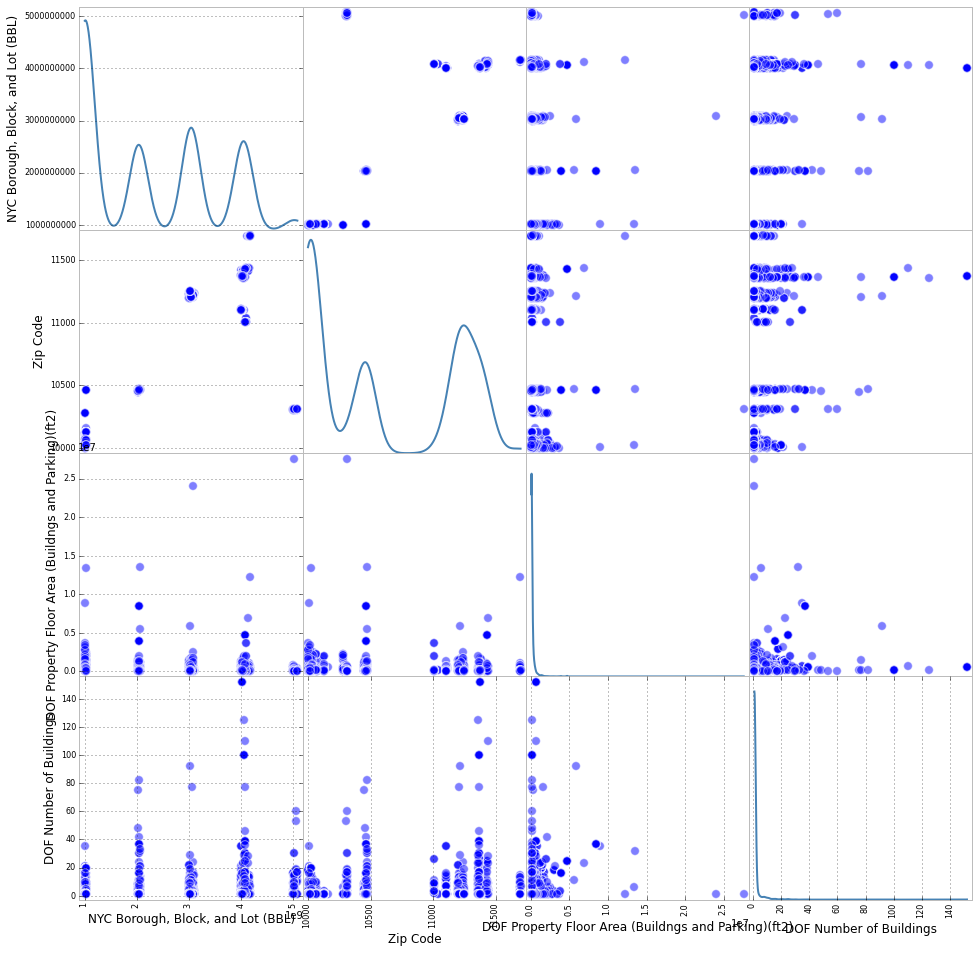

In [4]:
from pandas.tools.plotting import scatter_matrix
scatter_matrix (nrg, s=300, figsize=(16, 16), diagonal='kde')

it will show me correlations between variables, but it will also show me what can and 
cannot be plotted trivially in my dataset! here only a few columns can be plotted: 
those that contain only numbers (and possibly NaN's), but most columns contain rows that cannot be converted to float (e.g. entries like 'See Primary BBL' in several rows for the energy dataframe 'Site EUI(kBtu/ft2) ' column) , so Pandas refuses to plot them, cause it does not know what to do with those entries. 
The columns I am interested in are in fact u'Site EUI(kBtu/ft2)' which is a measure of the energy consumed PER SQ FOOT by a building, and then the building area: for eg.       u'Reported Property Floor Area (Building(s)) (ft²)'. Neither gets plotted: i need to remove all values that cannot conver to float in order to use the columns and convert them to float arrays and do math with them. 

Below I created a function that returns True if what is passed as argument can be converted to a float, and False otherwise. I do it with the Try/Except structure. it is a very useful python functionality that you should look into.  
this has to be done entry by entry: if you gve t a series you get error "cannot convert the series to <type 'float'>"

However you can pass it a whole array by using it in conjunction with
np.vectorize (look up the syntax!) which will implement a for loop for you under the hood to pass the series entry by entry to your function.


In [ ]:
#def canconvert(mydata):
#    try :
#        float(mydata)
#        return True
#    except ValueError:
#        return False
    

Now for every column i care about i can create an array, call it for eg. indx, of True and False (a Boolean array) that i can use as an index to pick entries that 
I want to use from my arrays of interest. I can replace the entries that failed to be converted to 'NaN'

(because my function return Trues when I can convert and False otherwise i actuallly want the complementary array: ~indx)

In [ ]:
#create the indeces array here
#indx = [True] * len(nrg)
#for i in range(len(nrg)):
    #print nrg['Site EUI(kBtu/ft2)'][i+1]
#    itcan = canconvert(nrg['Site EUI(kBtu/ft2)'][i+1])
#    if ~itcan:
#        nrg['Site EUI(kBtu/ft2)'][i+1]=float('NaN')
nrg.head().transpose()

In [5]:
#nrg['Site EUI(kBtu/ft2)'][~indx]=float('NaN')

#nrg['Site EUI(kBtu/ft2)'] =nrg['Site EUI(kBtu/ft2)'].convert_objects(convert_numeric=True)
nrg['Reported Property Floor Area (Building(s)) (ft²)']=nrg['Reported Property Floor Area (Building(s)) (ft²)'].convert_objects(convert_numeric=True)
nrg['BBLs Co-reported'] =nrg['BBLs Co-reported'].convert_objects(convert_numeric=True)
nrg['Site EUI(kBtu/ft2)'] =nrg['Site EUI(kBtu/ft2)'].convert_objects(convert_numeric=True)
bsize['BBL'] = bsize['BBL'].convert_objects(convert_numeric=True)
##etc etc... for all columns you care about

In [6]:
##check that your conversion worked: e.g.
print nrg['Site EUI(kBtu/ft2)'].astype(float)
print nrg['Reported Property Floor Area (Building(s)) (ft²)'].astype(float)
print nrg['BBLs Co-reported'].astype(float)
#[...] check all columns you care about in both datasets. 
#Nan's are ok, but you must not get an error when you try the conversion
#the Pluto data is much better at not using spurious entries for numerical value columns. 
#but check you can use the columns you want
print bsize.BBL.astype(float)
#notice i can use the attribute notation to refer to columns in bsize, 
#cause the column names do not have spaces!

Record Number
16099      180.5
500         82.1
5017       137.7
5116       103.2
363         74.0
6876        36.4
10714      114.8
1214       130.0
1544       138.3
1905     56909.0
2301        88.2
15059       15.7
674          NaN
2537        85.7
2841       195.7
2945        79.1
15120      144.1
3053       200.9
4233       104.6
4777        86.7
4912       102.1
5210        21.2
5295        78.3
1575         NaN
15025       55.2
4208        83.2
4799       145.1
1568        59.4
5427        88.7
5476       100.8
          ...   
14559        NaN
14560        NaN
14748        NaN
14753        NaN
13582        NaN
13947        NaN
14777        NaN
14779        NaN
14409        NaN
13262        NaN
13261        NaN
12523        NaN
12529        NaN
12536        NaN
13929        NaN
13944        NaN
13945        NaN
13821        NaN
13829        NaN
13837        NaN
13838        NaN
13847        NaN
14352        NaN
12976        NaN
12978        NaN
12984        NaN
12987        NaN


#TO MERGE THE DATASET WE NEED A COMMON COLUMN
here is where you want to merge the datasets. You need a common column: the building id BBL
However the name of this variable (column) in the Energy dataset is     'NYC Borough, Block, and Lot (BBL)'. create a column 'BBL' in the nrg dataset to pass it to the 'on' keyword argument of the merge pandas method: pd.merge(..... on=['BBL']) will use the common column 'BBL' to join the information from the 2 datasets for each BBL value (check out the complete syntax!) 

In [7]:
nrg['BBL'] = nrg['NYC Borough, Block, and Lot (BBL)']
bblnrgdata = pd.merge(nrg,bsize,left_on='BBL',right_on='BBL', how='inner')
bblnrgdata.head().transpose()

/Users/arp504/anaconda/lib/python2.7/site-packages/pandas/core/index.py:1695: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  indexer = self._engine.get_indexer(target.values)
/Users/arp504/anaconda/lib/python2.7/site-packages/pandas/core/index.py:1049: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  return key in self._engine


,0,1,2,3,4
"NYC Borough, Block, and Lot (BBL)",1.00505e+09,1.02142e+09,1.02175e+09,1.00336e+09,1.00807e+09
Co-reported BBL Status,NaN,NaN,NaN,NaN,NaN
BBLs Co-reported,1.00505e+09,1.02142e+09,1.02175e+09,1.00336e+09,NaN
Reported NYC Building Identificaiton Numbers (BINs),1007817,1063495,1064235,1088884,1015181
Street Number,150,4079,60,16,119
Street Name,VARICK STREET,BROADWAY,SHERMAN AVENUE,BIALYSTOKER PLACE,WEST 31 STREET
Borough_x,Manhattan,Manhattan,Manhattan,Manhattan,Manhattan
Zip Code,10013,10032,10040,10002,10001
DOF Benchmarking Submission Status,Filed,Filed,Filed,Filed,Filed
Site EUI(kBtu/ft2),82.1,137.7,103.2,74,130


once you have the dataframe with all the info you want, you want to plot 
Energy vs Number of Units in the Building. 
Remember: Energy TOTAL, not per sq ft...
Here you can choose what you think makes more sense for the number of units: all units, residential units...
make a 'natural' scale scatter plot first it will look really bad cause all the datapoints are at very low Unit numbers while the Unit number range actually goes up to 8000.
perhaps zoom into the region where most points are by cutting your x and y axis plotted: e,g, use xlim=(1000,1e10), ylim=(1,1000), where the numbers to be plugged in depend on exactly what you chose to plot

6545
6545


/Users/arp504/anaconda/lib/python2.7/site-packages/pandas/core/index.py:1572: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  return self._engine.get_loc(_values_from_object(key))


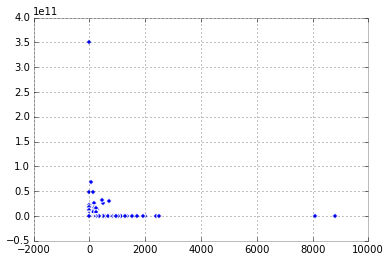

In [8]:
import statsmodels.api as sm
Totalenergy =bblnrgdata['Reported Property Floor Area (Building(s)) (ft²)']*bblnrgdata['Site EUI(kBtu/ft2)'] 

Xo = bblnrgdata['UnitsTotal']
Xo1 = sm.add_constant(np.log10(bblnrgdata['UnitsTotal']))
Xo2 = np.log10(bblnrgdata['UnitsTotal'])
print len(Xo)
Yo = Totalenergy
Yo1 = np.log10(Totalenergy)
Yo2 = sm.add_constant(np.log10(Totalenergy))
print len(Yo)
plt.scatter(Xo,Yo)

(0, 100000000000.0)

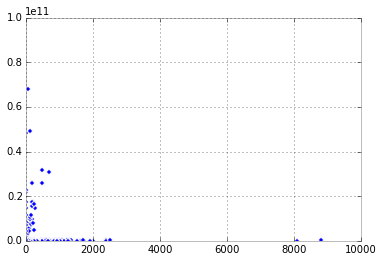

In [9]:
plt.scatter(Xo,Yo)
plt.xlim(0,1e4)
plt.ylim(0,1e11)

when the points in a plot all look scrunched against the axis try a log plot! in pandas you enable that with the keyword 'loglog' :
bblnrgdata.plot(..... loglog=True)

NOTICE THAT YOU WILL STILL HAVE TO CUT YOUR DATASET! in my data i had a lot of energy datapoints that were exactly 0. I removed these "outliers" which I think are truly outliers in the sense that they are misreported numbers. you can remove the data that have nrg==0 (or nrg < some sensible threshold choice) by indexing your array:
something like bblnrgdata_cut = bblnrgdata[bblnrgdata.nrg>1000]

also i removed the buildings with several thousand units. points like that at the edge of my range would have a lot of "LEVERAGE", however  they are not suprious entries like the 0, which i believe are missing values, or perhaps abandoned lots. these are good datapoint that i need to throw away functionally for my analysis to work, but that should be stated clearly.


Now fit a line through the data. you can use whatever you want to do it: 
statsmodels, scipy, any other package, or write your own minimization of the residuals
## BUT REMEMBER: we see hints of a lienar relation in log space! so we want to fit a line to the log of our variables, not the variables themselves:

if you used statsmodels it would look something like this:

In [10]:
import statsmodels.api as sm

bblnrgdata['Energy Consumption (kBtu)'] = bblnrgdata['Reported Property Floor Area (Building(s)) (ft²)']*bblnrgdata['Site EUI(kBtu/ft2)'] 

bblnrgdata_cut = bblnrgdata[(bblnrgdata['Energy Consumption (kBtu)']>1000) & (bblnrgdata['Energy Consumption (kBtu)']<1e+10) & (bblnrgdata['UnitsTotal']>10) & (bblnrgdata['UnitsTotal']<1000)]
    
print len(bblnrgdata),len(bblnrgdata_cut) #,len(bblnrgdata_cut1)
Totalenergy =bblnrgdata_cut['Reported Property Floor Area (Building(s)) (ft²)']*bblnrgdata_cut['Site EUI(kBtu/ft2)'] 

print len(bblnrgdata),len(bblnrgdata_cut) #,len(bblnrgdata_cut1)
X = bblnrgdata_cut['UnitsTotal']
X1 = sm.add_constant(np.log10(bblnrgdata_cut['UnitsTotal']))
X2 = np.log10(bblnrgdata_cut['UnitsTotal'])
print len(X)
Y = Totalenergy
Y1 = np.log10(Totalenergy)
Y2 = sm.add_constant(np.log10(Totalenergy))
print len(Y)
model1 = sm.OLS(Y1, X1, missing='drop') # ignores entires where x or y is NaN
fit1 = model1.fit()
print fit1.params[1], fit1.params[0], fit1.summary() # could also return stderr in each via fit.bse
model2 = sm.OLS(X2, Y2, missing='drop') # ignores entires where x or y is NaN
fit2 = model2.fit()
print fit2.params[1], fit2.params[0], fit2.summary() # could also return stderr in each via fit.bse

6545 4202
6545 4202
4202
4202
0.482469727186 6.1063971107                             OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.181
Model:                            OLS   Adj. R-squared:                  0.181
Method:                 Least Squares   F-statistic:                     931.2
Date:                Tue, 13 Oct 2015   Prob (F-statistic):          6.73e-185
Time:                        16:24:42   Log-Likelihood:                -2113.1
No. Observations:                4202   AIC:                             4230.
Df Residuals:                    4200   BIC:                             4243.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------

In [ ]:
bblnrgdata_cut

remember to choose wisely which is your DEPENDENT and which is your INDEPENDENT variable. 
both for what you want to do logically (what changes as a functino of what) but also based on which  variable has a 'sensible' distribution that allows you to fit a function to it: 
    you need your independent variable to span a large range, and to be spread somewhat evenly in the range, 
    rather than just clustered in a spot
    


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.181
Model:                            OLS   Adj. R-squared:                  0.181
Method:                 Least Squares   F-statistic:                     931.2
Date:                Tue, 13 Oct 2015   Prob (F-statistic):          6.73e-185
Time:                        17:06:30   Log-Likelihood:                -2113.1
No. Observations:                4202   AIC:                             4230.
Df Residuals:                    4200   BIC:                             4243.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          6.1064      0.031    199.843      0.000         6.046     6.166
UnitsTotal     0.4825      0.016     30.515      0.000         0.451     0.513
==============================================================================
Omnibus:                     1449.500   Durbin-Watson:                   1.588
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            22731.456
Skew:                           1.215   Prob(JB):                         0.00
Kurtosis:                      14.132   Cond. No.                         12.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

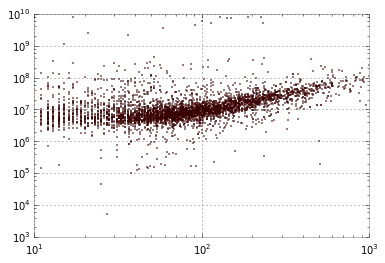

In [38]:
#fit and plots here
import matplotlib.pyplot as plt
plt.loglog(X,Y,'ro',ms=1)
fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             UnitsTotal   R-squared:                       0.181
Model:                            OLS   Adj. R-squared:                  0.181
Method:                 Least Squares   F-statistic:                     931.2
Date:                Tue, 13 Oct 2015   Prob (F-statistic):          6.73e-185
Time:                        17:09:50   Log-Likelihood:                -1590.0
No. Observations:                4202   AIC:                             3184.
Df Residuals:                    4200   BIC:                             3197.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -0.7476      0.087     -8.623      0.000        -0.918    -0.578
None           0.3761      0.012     30.515      0.000         0.352     0.400
==============================================================================
Omnibus:                      187.221   Durbin-Watson:                   1.337
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              215.500
Skew:                          -0.514   Prob(JB):                     1.60e-47
Kurtosis:                       3.415   Cond. No.                         114.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

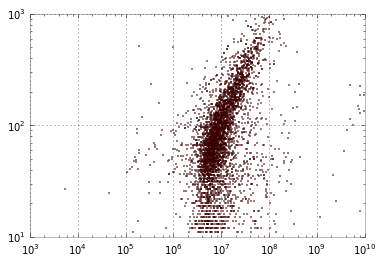

In [39]:
plt.loglog(Y,X,'ro',ms=1)
fit2.summary()

try making a fit for energy vs units AND a fit for units vs energy. 
tell me which is better. 

##look at the fit summary: which is better? could you do a likelihood ratio test here? why or why not??

#answer the question here
<STRONG>Which summary is better?</Strong><BR>
The second summary is better because it has:<BR>
<UL><li>Kurtosis of  3.415 for the second one vs 14.132</li>

##now fit a second degree curve to it: a*x^2+b*x+c. 
that is still called a linear fir by the way, the "linear" definition refers to the PARAMETERS being linear, not to the variable!
you can use np.polyfit for example (an example showned in the other assignment notebook), with order 2 instead of 1,

np.polyfit(x, y, 2)

or statmodels.formula.api passing a formula like 

formula = 'y ~ 1 + x + I(x ^ 2.0)'

##look at the fit summary: which is better? could you do a likelihood ratio test here? why or why not??

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     3.522
Date:                Tue, 13 Oct 2015   Prob (F-statistic):             0.0296
Time:                        16:58:26   Log-Likelihood:                -89230.
No. Observations:                4202   AIC:                         1.785e+05
Df Residuals:                    4199   BIC:                         1.785e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   1.616e+07   1.12e+07      1.438      0.1

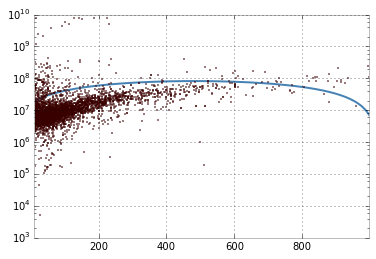

In [34]:
import statsmodels.formula.api as smf
data3 = pd.DataFrame({'X':X,'Y':Y})
#print data3
fit3 = np.polyfit(X,Y,2)
lm = smf.ols(formula='Y ~ 1+X+I(X**2)', data = data3).fit()
print lm.summary()
print fit3
x3 = np.arange(min(X), max(X), 0.1);
y3 = fit3[0] *x3**2 + fit3[1]*x3 + fit3[2]
plt.plot(x3, y3)
plt.plot(X,Y,'or',ms=1)
#plt.ylim(1000,500000000)
plt.xlim(min(X), max(X))
#plt.xscale('log')
plt.yscale('log')

                            OLS Regression Results                            
Dep. Variable:                      X   R-squared:                      -0.778
Model:                            OLS   Adj. R-squared:                 -0.779
Method:                 Least Squares   F-statistic:                    -1838.
Date:                Tue, 13 Oct 2015   Prob (F-statistic):               1.00
Time:                        16:58:07   Log-Likelihood:                -27513.
No. Observations:                4202   AIC:                         5.503e+04
Df Residuals:                    4200   BIC:                         5.504e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   8.262e-16   5.82e-17     14.192      0.0

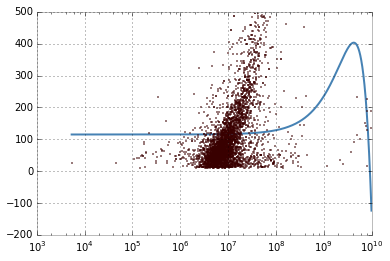

In [33]:
data4 = pd.DataFrame({'X':X,'Y':Y})
#print data4
fit4 = np.polyfit(Y,X,2)
lm = smf.ols(formula='X ~ 1+Y+I(Y**2)', data = data4).fit()
print lm.summary()
print fit4
y4 = np.arange(min(Y), max(Y), 10000);
x4 = fit4[0] *y4**2 + fit4[1]*y4 + fit4[2]
plt.plot(y4, x4)
plt.plot(Y,X,'or',ms=1)
plt.ylim(-200,500)
plt.xscale('log')



<STRONG>Which summary is better?</Strong><BR>
The second summary is better because it has:<BR>
<UL><li>Kurtosis of  13.638 for the second one vs 386.261</li>
<br>
We can use the likelihood test
in the first model we have: Log-Likelihood:-2113.1
in the second degree model we have: Log-Likelihood:-89230

If all the models would have the same number of unknown parameters, and there is no reason to choose one particular model over another based on the failure mechanism or previous successful analyses, then pick the model with the largest likelihood value. 

In this case the largest likelihood value is the first model with -2113.1.


EXTRA CREDIT: 
    
use WLS the weighted sq fit instead of OLS. you need to give weights to your points: 
estimates of the errors. the easiest thing is the sqrt of the datapoint value.
if you want to be more sophisticated you can estimate the variance of your data
near each point and use that 

Lastly: do it by hand and create a function that minimizes the residuals: 
       
the residuals are the sum of the differences between data and model: 
in the case of a line fit model (and you can use your errors if you did the extra credit!)

sum(np.log(bblnrgdatacut.nrg) - np.log(bblnrgdatacut.UnitsTotal)*a+b )^2

where a and b are the parameters returned by the line fitter. 
for each data point you can calculate the model at different values : for example in a range B = np.arange (-100, 100, 1) for the intercept, and A = np.arange(-50.0, 50.0, 0.5) for the slope

write it as a nested for loop (or challenge yourself and vectorize it!) with a loop inside another ranging all poissible combinations of the 2 variables (i use enumerate to get both an index from 0 to the size of my array, which i assign to i (and j) and the value of the array at that index - look up the syntax!):


for i,a in enumerate(A):

    for j,b in enumerate(B):
    
         Lsurface[i][j].....

this gives you a 2D array that represents your likelihood surface! what we do to find a good fit is find the minimum (lowest point) on this surface. 

you can plot a surface (a 2D array) with pl.imshow(Lsurface) as a "heatmap"

but when you do that you will find that the plot is very uninformative. just like you did before with the data, plot the log of it (pl.imshow(np.log(Lsurface))
and see if it helps!
also make sure your x and y axes tick numbers represent the range of values, not the cell index, which is the default for imshow. do that with the keyword extent: 
pl.imshow(Lsurface, .... , extent = [minimum, and max of your y array, minimum, and max of your x array]...) (notice that the numbers are switched! make sure to verify which axis is the slope, which is the intercept)

In [ ]:
##create the array
##[...]
##pl.figure(figsize=(10,10))
##pl.title ("log likelihood surface", fontsize = 22)
##pl.imshow(np.log(Lsurface), extent = ..., aspect=...)
##[...]
##pl.colorbar()

EXTRA CREDIT: get creative with the dataset! can you make an insigntful plot to show any structure in the data?
    
below is my silly attempt at that




In [ ]:
bblnrgdatacut['YearBuilt'][bblnrgdatacut['YearBuilt']<1800]=1800

bblnrgdatacut.plot(kind='scatter',x='nrg',y='UnitsTotal', fontsize=22, colormap='gist_rainbow', alpha = 1, marker='o',  figsize=(16, 14), loglog=True,  xlim=(1000,1e11), ylim=(1,1000), c=bblnrgdatacut['YearBuilt']-1900, s=bblnrgdatacut['UnitsTotal']/bblnrgdatacut['UnitsRes']*100)